# Latitude by Latitude Land Adaptation of Aquaplanet Theory
This looks at applying the aquaplanet theory to the extratropics of land to each latitude individually and then does an area weighted average of each latitude in a given region.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.extrop_land_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import warnings

2023-07-04 16:31:58,253 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]
max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']
p_surface = float(ds[0].pfull) * 100  # pressure where surface temperature is computed - same for all ds

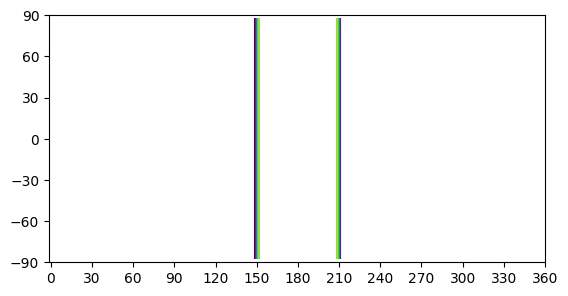

In [4]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get two datasets, `ds_all`, one for ocean and one for land, for a given latitude bin.

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [28]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) < lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)

100%|██████████| 4/4 [00:22<00:00,  5.59s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [29]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
surfaces = ['ocean', 'land']
n_surf = len(surfaces)

quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all['ocean'][0].temp.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all['ocean'][0].lat))     # latitude area weighting is just the cosine

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
# mse as function of mse quantile not temp quantile
mse_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}

with tqdm(total=n_exp*n_surf, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in surfaces:
            temp_quant2[surf][i] = ds_all[surf][i].temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            sphum_quant2[surf][i] = ds_all[surf][i].sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            mse = moist_static_energy(ds_all[surf][i].temp, ds_all[surf][i].sphum, ds_all[surf][i].height)
            mse_quant2[surf][i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
            pbar.update(1)

100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


## Land to Ocean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3

The scaling $\lambda(p) = \frac{\delta h_L(p)}{\delta h_O(p)}$, is very close to 1 for all percentiles, implying that the theory may be appropriate.

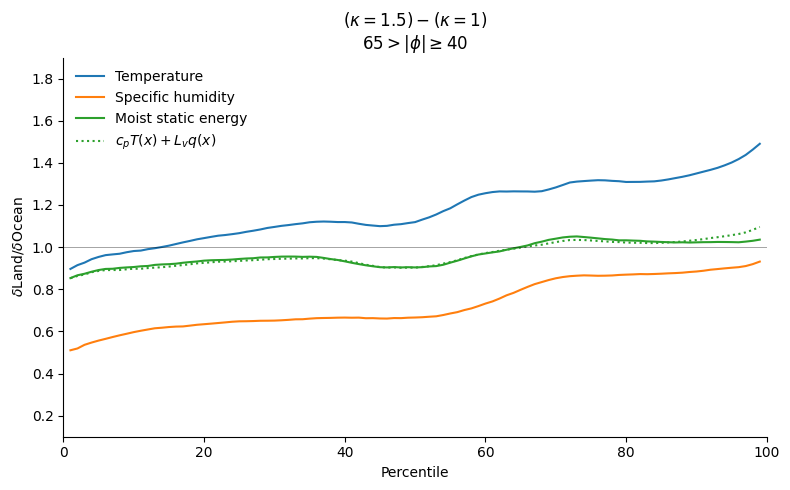

In [30]:
save_lambda_fig = False
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# don't plot the p=0 percentile as doesn't really make any sense
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    var_ratio = (var['land'][1]-var['land'][0])/(var['ocean'][1]-var['ocean'][0])
    ax.plot(quant_plot, np.average(var_ratio, axis=0, weights=lat_weights), label=labels[i])
ax.plot(quant_plot, np.average(np.diff(c_p * temp_quant2['land'] + L_v * sphum_quant2['land'], axis=0)[0]/
                               np.diff(c_p * temp_quant2['ocean'] + L_v * sphum_quant2['ocean'], axis=0)[0],
                               axis=0, weights=lat_weights), color=default_colors[2], linestyle=':', label='$c_p T(x) + L_v q(x)$')
delta_mse_ratio = var_ratio
ax.hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
ax.legend(loc='upper left', framealpha=1, edgecolor='w')
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta$Land/$\delta$Ocean')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.set_ylim(0.1,1.9)
ax.set_xlim(0, 100)
plt.tight_layout()
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for $\delta T(p)$

### Form of MSE equation to start theory
From the above plot, we have $\delta h_L(p) = \delta h_O(p)$. In the extratropics, it seems that higher temperatures are associated with higher moist static energies.

Thus, we expect equation 10 in the paper: $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ should hold for both land and ocean. In the plot below, we see that this is the case to within around $5\%$.

So now we can obtain an equation for $\delta T(p)$, the temperature change of the percentile $p$ of temperature. This is simpler than what is done in the paper where it cannot assume $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ over land, so it instead considers the temperature change of days averaged over a given percentile, $x$, in temperature: $\delta T^x$.

Importantly, if we just consider $\delta T(p)$, we no longer have to think abut the problematic $\Delta h$ term.

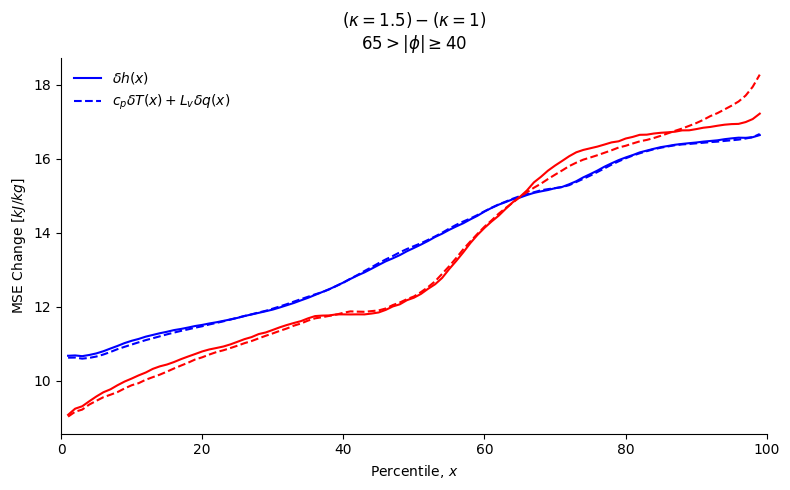

In [31]:
save_delta_mse_fig = False
plt_color = {'land': 'red', 'ocean': 'blue'}
fig_delta_mse, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for surf in surfaces:
    ax.plot(quant_plot, np.average(mse_quant2[surf][1]-mse_quant2[surf][0], axis=0, weights=lat_weights),
            label = '$\delta h(x)$' if surf=='ocean' else None, color=plt_color[surf])
    ax.plot(quant_plot, np.average(c_p * (temp_quant2[surf][1]-temp_quant2[surf][0]) +
                                   L_v * (sphum_quant2[surf][1]-sphum_quant2[surf][0]), axis=0, weights=lat_weights)/1000,
            label='$c_p \delta T(x) + L_v \delta q(x)$' if surf=='ocean' else None, color=plt_color[surf], linestyle='--')
ax.legend(frameon=False)
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.set_xlim(0,100)
plt.tight_layout()

if save_fig or save_delta_mse_fig:
    fig_delta_mse.savefig(f"/Users/joshduffield/Desktop/delta_mse_{region.lower()}_{season}",
                          dpi=high_dpi if publish_fig else low_dpi)

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [32]:
temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_quant2['ocean'][:, i], sphum_quant2['ocean'][:, i], temp_quant2['land'][:, i],
                                        sphum_quant2['land'][:, i], p_surface,
                                        const_rh=True if method=='const_rh' else False,
                                        delta_mse_ratio=delta_mse_ratio[i:i+1] if 'lambda' in method else None,
                                        taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')

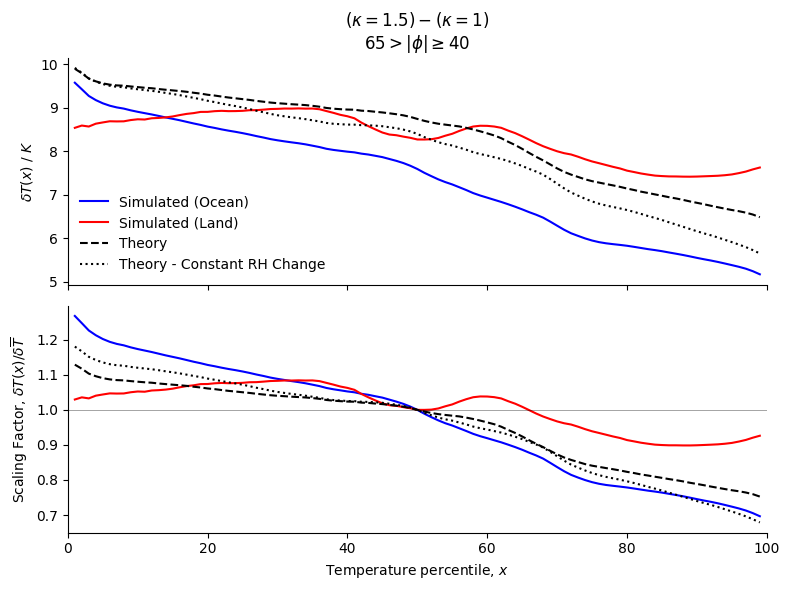

In [33]:
# take median as average rather than mean because theory does not predict change to mean temperature
av_quant_ind = np.where(quant_plot==50)[0]
save_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for surf in surfaces:
    ax[0].plot(quant_plot, np.average(temp_quant2[surf][1]-temp_quant2[surf][0], axis=0, weights=lat_weights),
               label = f'Simulated ({surf.capitalize()})', color=plt_color[surf])
    ax[1].plot(quant_plot,
           np.average((temp_quant2[surf][1]-temp_quant2[surf][0])/(temp_quant2[surf][1]-temp_quant2[surf][0])[:, av_quant_ind],
                      axis=0, weights=lat_weights), color=plt_color[surf])
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['const_rh'], axis=0, weights=lat_weights), color='k',
           label='Theory - Constant RH Change', linestyle=':')

ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['const_rh']/temp_diff_theory['const_rh'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].legend(frameon=False)
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.89, 1.25)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T_L(x) = \gamma^T \delta T_O(x) + \gamma^{\Delta r} \delta (r_O(x)-r_L(x))$ and the dotted line is just $\gamma^T \delta T_O(x)$. The plots below show how these $\gamma$ factors vary with percentile.

In [34]:
gamma_t = np.zeros((n_lat, n_quant))
gamma_rdiff = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    all_gamma = get_gamma(temp_quant2['ocean'][:, i], sphum_quant2['ocean'][:, i],
                          temp_quant2['land'][:, i], sphum_quant2['land'][:, i], p_surface)
    gamma_t[i] = all_gamma[0][0]
    gamma_rdiff[i] = all_gamma[1][0]

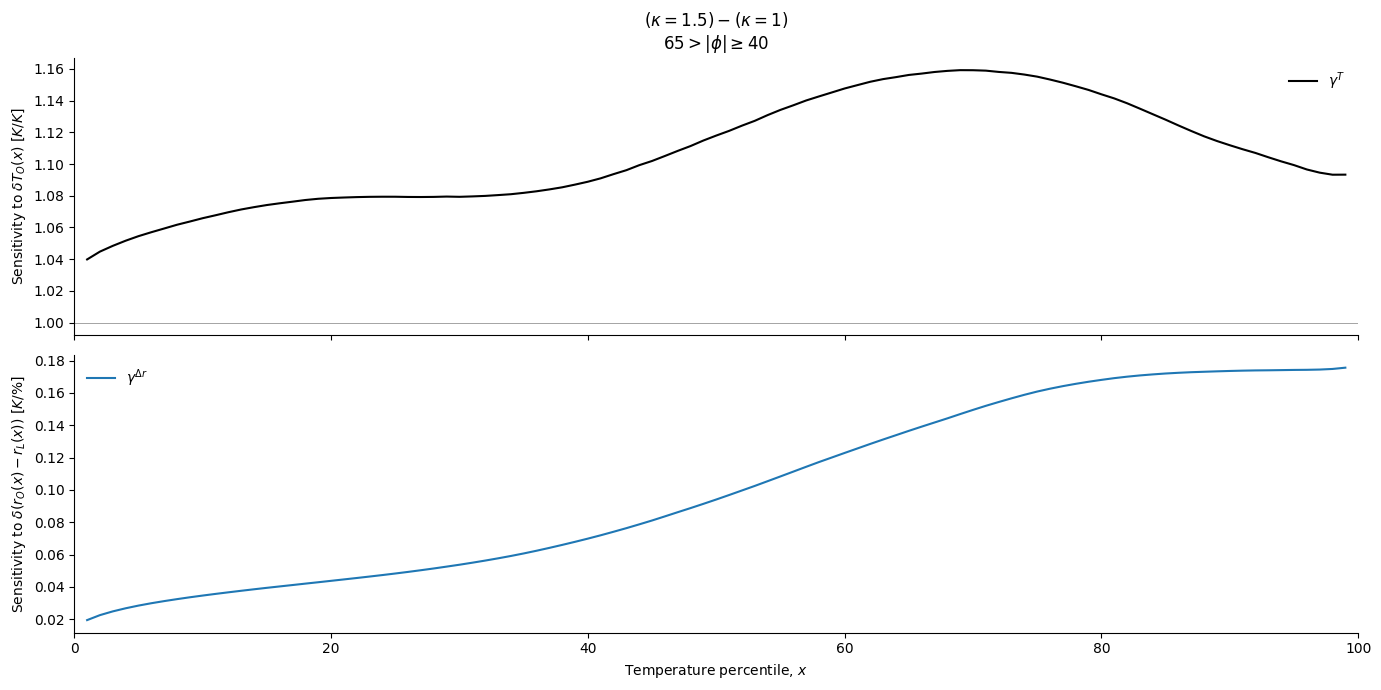

In [35]:
save_gamma_fig = False
fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(gamma_t, axis=0, weights=lat_weights), color='k', label='$\gamma^T$')
ax[1].plot(quant_plot, np.average(gamma_rdiff / 100, axis=0, weights=lat_weights), color=default_colors[0],
           label='$\gamma^{\Delta r}$')
ax[0].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].set_ylabel('Sensitivity to $\delta T_O(x)$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (r_O(x) - r_L(x))$ [$K/$%]')
ax[0].set_xlim(0, 100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h_L(x)/\delta h_O(x) = 1$

    The validity of this is shown by the green line in the $\delta Land/\delta Ocean$ plot. This should be equal to 1.
    In the top plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the top plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (red line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

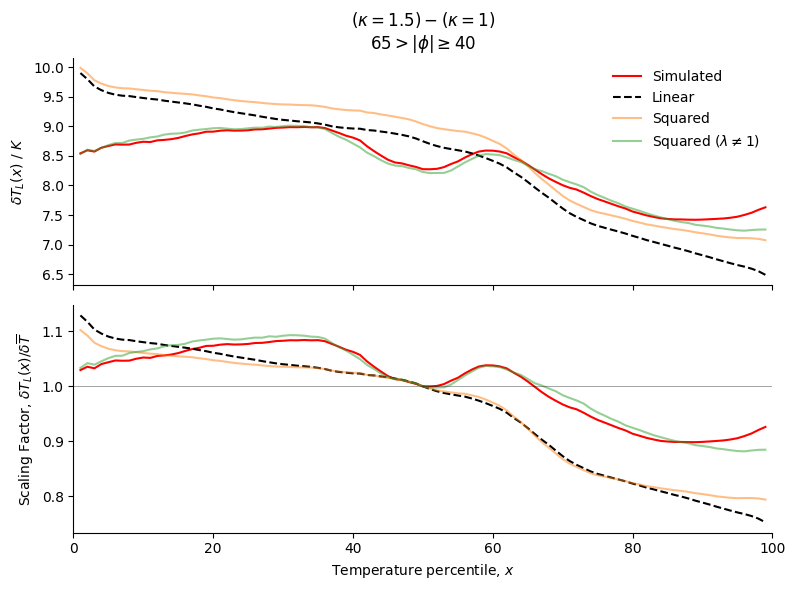

In [36]:
save_approx_fig = False
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(temp_quant2['land'][1]-temp_quant2['land'][0], axis=0, weights=lat_weights), label = 'Simulated',
           color=plt_color['land'])
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Linear')
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared'], axis=0, weights=lat_weights), color=default_colors[1],
           label='Squared', alpha=0.5)
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared_lambda'], axis=0, weights=lat_weights), color=default_colors[2],
           label='Squared ($\lambda \\neq 1$)', alpha=0.5)
ax[1].plot(quant_plot,
           np.average((temp_quant2['land'][1]-temp_quant2['land'][0])/(temp_quant2['land'][1]-temp_quant2['land'][0])[:, av_quant_ind],
                      axis=0, weights=lat_weights), label = 'Simulated', color=plt_color['land'])
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared']/temp_diff_theory['squared'][:, av_quant_ind], axis=0, weights=lat_weights),
           color=default_colors[1], alpha=0.5)
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared_lambda']/temp_diff_theory['squared_lambda'][:, av_quant_ind],
                                  axis=0, weights=lat_weights), color=default_colors[2], alpha=0.5)

ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].legend(frameon=False)
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T_L(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T_L(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ land day is less than on the percentile $x$ ocean day, $\delta (r_O(x) - r_L(x)) > 0$, we get a positive contribution to $\delta T_L(x)$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

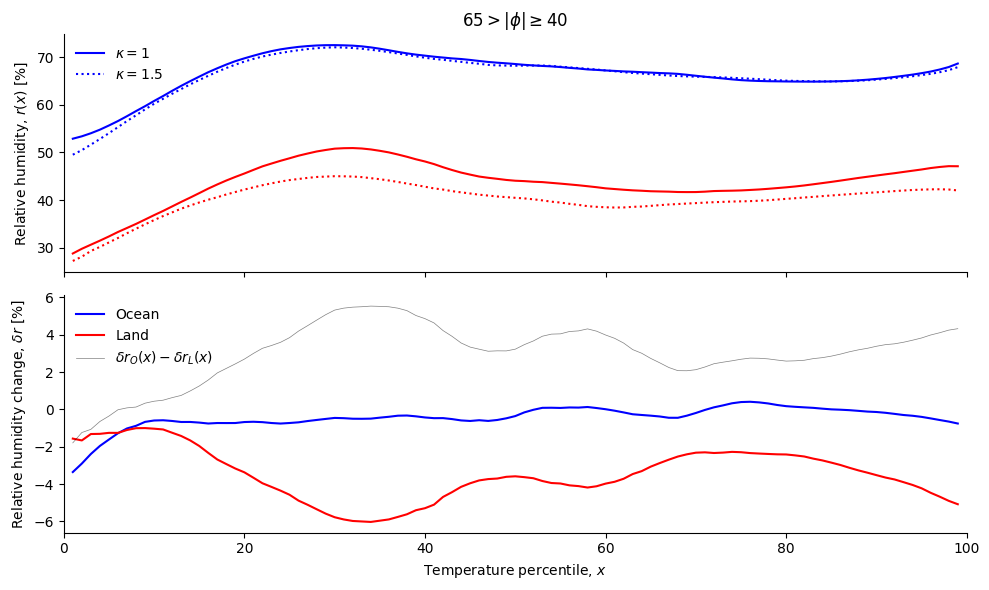

In [37]:
r_quant2 = {surf: sphum_quant2[surf] / sphum_sat(temp_quant2[surf], p_surface) * 100 for surf in surfaces}

save_rh_fig = False
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for surf in surfaces:
    ax[1].plot(quant_plot, np.average(r_quant2[surf][1]-r_quant2[surf][0], axis=0, weights=lat_weights),
           color=plt_color[surf], label=surf.capitalize())
    for i in range(n_exp):
            ax[0].plot(quant_plot, np.average(r_quant2[surf][i], axis=0, weights=lat_weights),
                       color=plt_color[surf], label=f'$\kappa={tau_lw[i]}$' if surf=='ocean' else None,
                       linestyle='-' if i==0 else ':')
ax[1].plot(quant_plot,
           np.average((r_quant2['ocean'][1]-r_quant2['ocean'][0]) - (r_quant2['land'][1]-r_quant2['land'][0]), axis=0,
                      weights=lat_weights), color='k', label='$\delta r_O(x) - \delta r_L(x)$', alpha=0.5, lw=0.5)
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r(x)$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r$ [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[0].set_title(f'${lat_max}>|\phi| \geq {lat_min}$')
# ax[0].set_ylim(58, 68)
# ax[1].set_ylim(0.2, 3.5)
plt.tight_layout()

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

### Specific Humidity
Plot specific humidity as a function of temperature percentile.


In [38]:
sphum_quant3 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
with tqdm(total=n_exp*n_surf*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in surfaces:
            for k in range(n_lat):
                for j, quant in enumerate(quant_plot):
                    # Take percentile to be temperature percentile
                    use_ind = get_quant_ind(ds_all[surf][i].temp[k], quant, 0.5, 0.5)
                    sphum_quant3[surf][i, k, j] = ds_all[surf][i].sphum[k, use_ind].mean()
                    pbar.update(1)

100%|██████████| 7128/7128 [00:35<00:00, 200.10it/s]


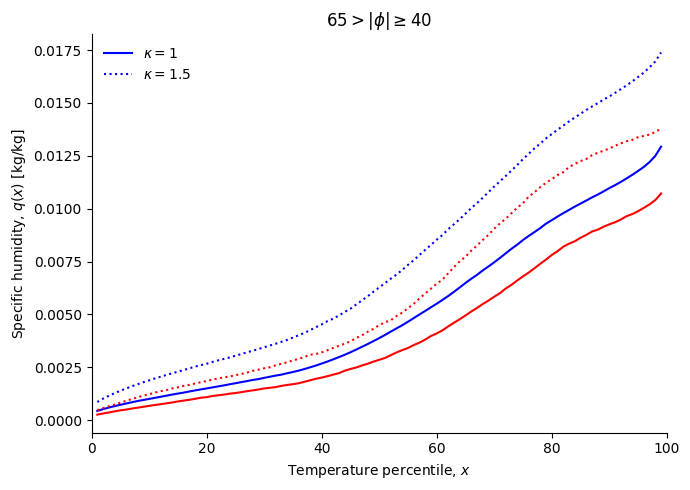

In [39]:
save_sphum_fig = False
fig, ax = plt.subplots(1,1, figsize=(7, 5), sharex=True)
ax.spines[['right', 'top']].set_visible(False)
for surf in surfaces:
    for i in range(n_exp):
            ax.plot(quant_plot, np.average(sphum_quant3[surf][i], axis=0, weights=lat_weights),
                       color=plt_color[surf], label=f'$\kappa={tau_lw[i]}$' if surf=='ocean' else None,
                       linestyle='-' if i==0 else ':')
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Specific humidity, $q(x)$ [kg/kg]')
ax.legend(frameon=False)
ax.set_title(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_sphum_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sphum_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Theory as function of latitude
The plot below shows how the theory works as a function of latitude for a subset of quantiles.

In [40]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

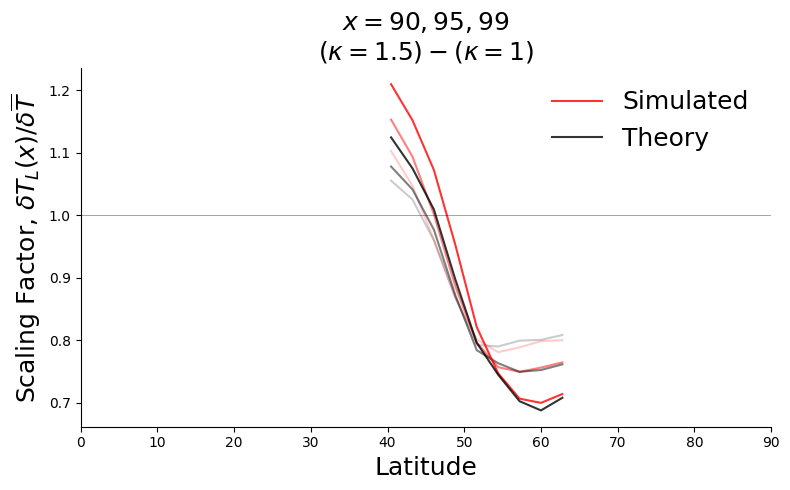

In [41]:
quant_subset = [90,95,99]
quant_subset_ind = numpy_indexed.indices(quant_plot, quant_subset)
lat_plot = ds_all['ocean'][0].lat[int(n_lat/2):]

big_font_size = 18      # for posters
theory_use = 'linear'
theory_use = 'squared_lambda'

save_theory_lat_fig = False
include_theory = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i in range(len(quant_subset)):
    ax.plot(lat_plot, abs_lat_av((temp_quant2['land'][1, :, quant_subset_ind[i]]-temp_quant2['land'][0, :, quant_subset_ind[i]])/
                                 (temp_quant2['land'][1]-temp_quant2['land'][0])[:, av_quant_ind[0]]), color=plt_color['land'],
            alpha=0.2+i*0.3,
            label='Simulated' if i==2 else None)
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_diff_theory[theory_use][:, quant_subset_ind[i]]/
                                     temp_diff_theory[theory_use][:, av_quant_ind[0]]), color='k', alpha=0.2+i*0.3,
                label='Theory' if i==2 else None)
ax.set_title(f"$x={','.join([str(x) for x in quant_subset])}$\n"
             f"$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$", fontsize=big_font_size)
ax.set_ylabel('Scaling Factor, $\delta T_L(x) / \delta \overline{T}$', fontsize=big_font_size)
ax.set_xlabel('Latitude', fontsize=big_font_size)
ax.hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
if include_theory:
    ax.legend(frameon=False, fontsize=big_font_size)
ax.set_xlim(0,90)
# ax.set_ylim(0.4, 1)
plt.tight_layout()
if (save_fig or save_theory_lat_fig) and region=='Global':
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/temp_theory_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## $\lambda$ Decompostion
Here, I break down the $\lambda=1$ approximation into three different factors. $\lambda_1$ represents CQE on the $x$ percentile land day. $\lambda_2$ represents the weak temperature gradient approximation and $\lambda_3$ represents CQE on the $x$ percentile ocean day.

In [42]:
# Load same exact dataset but for free troposphere pressure level not surface
pressure_ft = 500

ds_all_ft = {'land':[], 'ocean': []}
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
        ds_use = ds_use.sel(pfull=pressure_ft, method='nearest')      # only keep the surface and ft values
        ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_use = ds_use.load()
        for surf in ['land', 'ocean']:
            ds_all_ft[surf] += [ds_use.isel(lon_time=np.where(np.isin(ds_use.lon, np.unique(lon[surf])))[0])]
            pbar.update(1)
pressure_ft_actual = ds_all_ft['ocean'][0].pfull * 100

100%|██████████| 4/4 [00:22<00:00,  5.55s/it]


In [43]:
mse_ft_sat_quant2 = {'ocean': np.zeros((n_exp, n_lat, n_quant)), 'land': np.zeros((n_exp, n_lat, n_quant))}
with tqdm(total=n_exp*n_surf*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in surfaces:
            mse = moist_static_energy(ds_all[surf][i].temp, ds_all[surf][i].sphum, ds_all[surf][i].height)
            mse_ft = moist_static_energy(ds_all_ft[surf][i].temp, sphum_sat(ds_all_ft[surf][i].temp, pressure_ft_actual),
                                         ds_all_ft[surf][i].height)
            for k in range(n_lat):
                for j, quant in enumerate(quant_plot):
                    # Take percentile to be temperature percentile
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                    mse_ft_sat_quant2[surf][i, k, j] = mse_ft[k, use_ind].mean()
                    pbar.update(1)

100%|██████████| 7128/7128 [00:36<00:00, 197.76it/s]


In [44]:
lambda_1 = (mse_quant2['land'][1] - mse_quant2['land'][0]) / (mse_ft_sat_quant2['land'][1]-mse_ft_sat_quant2['land'][0])
lambda_2 = (mse_ft_sat_quant2['land'][1]-mse_ft_sat_quant2['land'][0]) / (mse_ft_sat_quant2['ocean'][1]-mse_ft_sat_quant2['ocean'][0])
lambda_3 = (mse_quant2['ocean'][1] - mse_quant2['ocean'][0]) / (mse_ft_sat_quant2['ocean'][1]-mse_ft_sat_quant2['ocean'][0])
labels = ['$\lambda(x) = \delta h_L(x)/\delta h_O(x) = \lambda_1(x) \lambda_2(x) \lambda_3^{-1}(x)$',
          '$\lambda_1(x) = \delta h_L(x) / \delta h_{L, FT, sat}(x)$',
          '$\lambda_2(x) = \delta h_{L, FT, sat}(x) / \delta h_{O, FT, sat}(x)$',
          '$\lambda_3(x) = \delta h_O(x) / \delta h_{O, FT, sat}(x)$',]

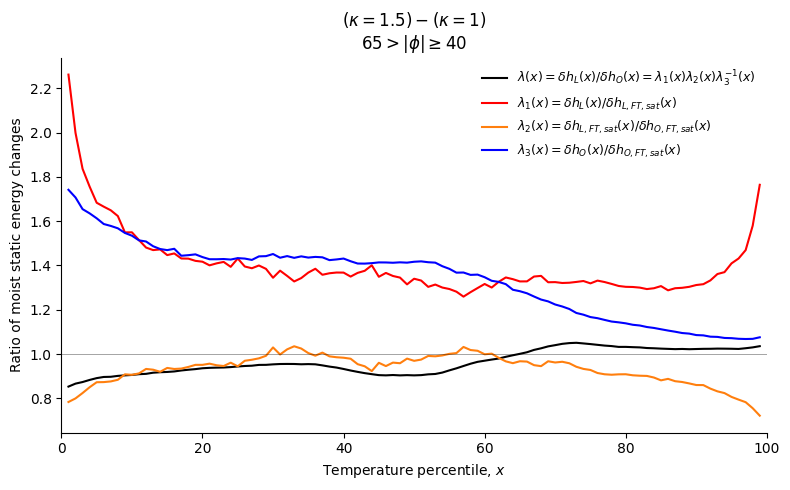

In [45]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
lambda_plot_colors = ['k', plt_color['land'], default_colors[1], plt_color['ocean']]
for i, var in enumerate([lambda_1*lambda_2/lambda_3, lambda_1, lambda_2, lambda_3]):
    ax.plot(quant_plot, np.average(var, axis=0, weights=lat_weights),
            color=lambda_plot_colors[i], label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
# ax.hlines(np.average(lambda_3, axis=0, weights=lat_weights), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=0.5, alpha=0.5)
ax.legend(framealpha=1, edgecolor='white', fontsize=9)
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Ratio of moist static energy changes')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

In the plot below, the quantiles in the order $90, 95, 99$ are represented in terms of lines of increasing opacity i.e. the darkest lines represent $x=99$.

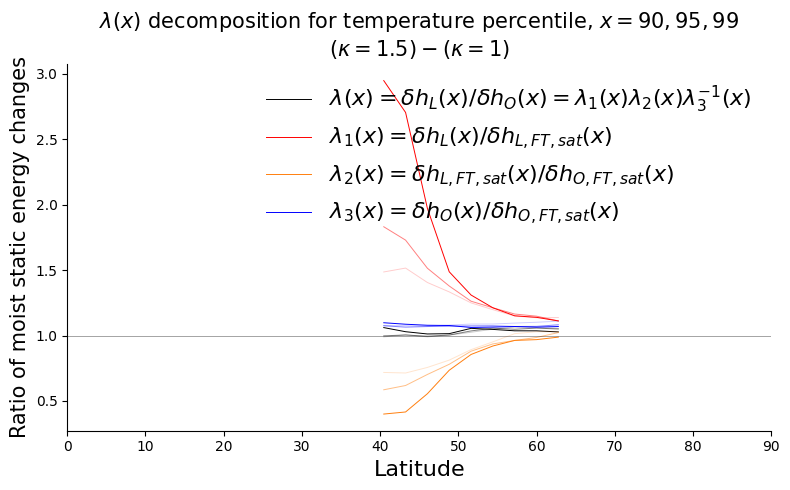

In [46]:
save_lambda_decomp_lat_fig = False
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
for i, var in enumerate([lambda_1*lambda_2/lambda_3, lambda_1, lambda_2, lambda_3]):
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[0]]), alpha=0.2, color=lambda_plot_colors[i], lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[1]]), alpha=0.5, color=lambda_plot_colors[i], lw=0.7)
    ax.plot(lat_plot, abs_lat_av(var[:, quant_subset_ind[2]]), alpha=1, color=lambda_plot_colors[i], label=labels[i], lw=0.7)
ax.hlines(1, -90, 90, color='k', lw=0.5, alpha=0.5)
ax.set_xlim(0, 90)
ax.legend(frameon=False, fontsize=big_font_size-2)
ax.set_xlabel('Latitude', fontsize=big_font_size-2)
ax.set_ylabel('Ratio of moist static energy changes', fontsize=big_font_size-3)
ax.set_title(f"$\lambda(x)$ decomposition for temperature percentile, $x={','.join([str(x) for x in quant_subset])}$\n"
             f"$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$", fontsize=big_font_size-3)
plt.tight_layout()
if (save_fig or save_lambda_decomp_lat_fig) and region=='Global':
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_lat_{season}",
                dpi=high_dpi if publish_fig else low_dpi)